In [1]:
%load_ext autoreload
%autoreload 2shange

In [2]:
# import osmnx as oximport pandas as pd
import geopandas as gpd
import mytools
import math
import numpy as np
from shapely.ops import unary_union
import pandas as pd

In [3]:
from shapely.geometry import Polygon,Point,LineString,MultiPolygon
import matplotlib.pyplot as plt
from descartes import PolygonPatch
import matplotlib.pyplot as plt
import simplekml

# 导入区域底图图层

In [4]:
quxian = mytools.gisn.maps('区县')

In [5]:
qingshan = quxian.loc[quxian['NAME']=='青山']

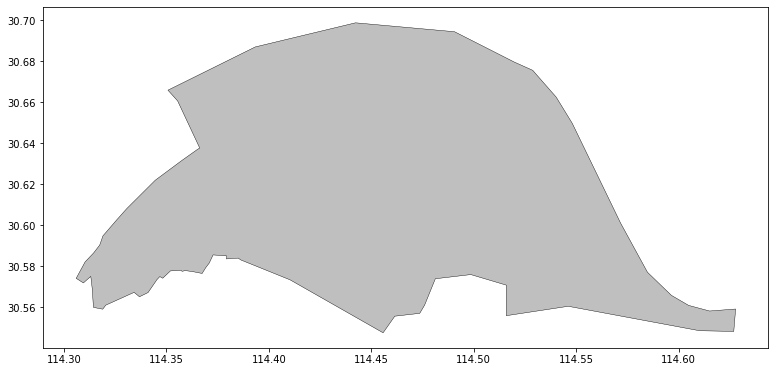

In [6]:
qingshan.plot(figsize =(13,13),color= '#BFBFBF',edgecolor='#000000', lw=0.4)#,k = 4, cmap = plt.cm.Greens

# 使用线条划分底图为栅格

In [7]:
#转化坐标系
qingshan = qingshan.to_crs({'init': 'epsg:32650'})
#去除geometry
geometry = qingshan['geometry'].iloc[0]
if isinstance(geometry, Polygon):
    geometry = MultiPolygon([geometry])
#用线划分geometry生成Mutipolygon
geometry_cut = mytools.gisn.quadrat_cut_geometry(geometry, quadrat_width=1000)
#替换geometry
qingshan['geometry'].iloc[0] = geometry_cut
#拆分MultiPolygon
qingshan_grid = qingshan.explode()
#转回坐标系
qingshan_grid = qingshan_grid.to_crs({'init': 'epsg:4326'})
#保留部分列
qingshan_res = qingshan_grid.reset_index()[['NAME','geometry']]
#添加id编号
qingshan_res['id'] = [ 'region_grid_{}'.format(str(name)) for name in qingshan_res.index+1]
#导出tab格式数据
qingshan_res.to_file('d:/qingshan.TAB',driver="MapInfo File",encoding='gbk')

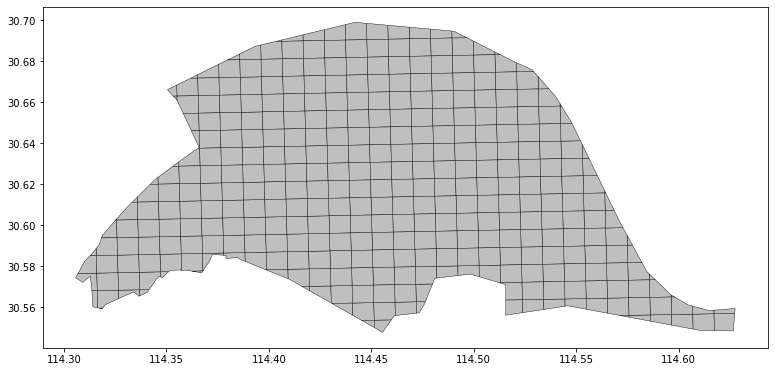

In [8]:
qingshan_res.plot(figsize =(13,13),color= '#BFBFBF',edgecolor='#000000', lw=0.4)

In [9]:
qingshan_res.shape

(361, 3)

# 导入栅格数据

In [10]:
wuhan_grid = pd.read_csv('G:/1-规划/评估/软采评估/2020年1季度/输出个地市的小区和栅格图层/栅格数据剔除重复项/武汉.csv',encoding='gbk')

In [11]:
wuhan_grid.head(1)

,城市,区县,grid_id,lon,lat,rsrp_sample_count,rsrp_weak,有效栅格,fgl,弱覆盖栅格数量,严重弱覆盖栅格数量
0,武汉,洪山,50RKU-458-801-100,114.351248,30.52683,4771430,13551,1.0,0.99716,NaN,NaN


In [12]:
wuhan_grid['弱覆盖栅格数量']=np.nan
wuhan_grid.loc[(wuhan_grid['有效栅格']==1) & (wuhan_grid['fgl']<0.936),'弱覆盖栅格数量']=1

In [13]:
wuhan_grid['严重弱覆盖栅格数量']=np.nan
wuhan_grid.loc[(wuhan_grid['有效栅格']==1) & (wuhan_grid['fgl']<0.7),'严重弱覆盖栅格数量']=1

In [14]:
qingshan_grid_data = wuhan_grid.loc[wuhan_grid['区县']=='青山']

In [15]:
qingshan_data_p = mytools.gisn.add_points(qingshan_grid_data,'lon','lat')

# 区域栅格和软采栅格数据匹配

In [16]:
res= gpd.sjoin(qingshan_res,qingshan_data_p)

In [17]:
res_groupby = res.groupby('id').agg({'rsrp_sample_count':'sum','rsrp_weak':'sum','grid_id':'count','有效栅格':'count','弱覆盖栅格数量':'count','严重弱覆盖栅格数量':'count'})

In [18]:
res_groupby = res_groupby.reset_index()

In [19]:
res_groupby.head(1)

,id,rsrp_sample_count,rsrp_weak,grid_id,有效栅格,弱覆盖栅格数量,严重弱覆盖栅格数量
0,region_grid_1,3080235,111791,54,54,25,2


In [20]:
res_groupby.shape

(352, 7)

# 区域栅格和投诉量匹配

In [21]:
#导入投诉数据

In [22]:
tousu = pd.ExcelFile('G:/1-规划/1其他工作输出/20200603青山按照大栅格划分问题点/3-分析top解决方案/1基础数据/广义投诉量/2020年广义投诉量1-4.xlsx')

In [23]:
tousu.sheet_names

['Sheet1']

In [24]:
tousu_1_4 = tousu.parse()

In [25]:
tousu_1_4.head(1)

,eNodeB名称,经度,纬度,eNodeBid,地市,站点类型,2020年1月投诉量,2020年2月投诉量,2020年3月投诉量,2020年4月投诉量,2020年投诉量
0,路易100-ZLH,114.31176,30.55209,440642,武汉,宏站,3,0,0,2,5


In [26]:
tousu_1_4.to_clipboard()

In [27]:
tousu_p = mytools.gisn.add_points(tousu_1_4,'经度','纬度')

In [28]:
res_tousu= gpd.sjoin(qingshan_res,tousu_p)

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2167: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


In [29]:
tousu_groupby = res_tousu.groupby('id').agg({'2020年投诉量':'sum'})

In [30]:
tousu_groupby = tousu_groupby.reset_index()

In [31]:
qingshan_res2 = res_groupby.merge(tousu_groupby,how='left',on='id')

# 结果放入区域栅格列中

In [32]:
qingshan_res2.sort_values('2020年投诉量',ascending=False)

,id,rsrp_sample_count,rsrp_weak,grid_id,有效栅格,弱覆盖栅格数量,严重弱覆盖栅格数量,2020年投诉量
13,region_grid_111,8146882,679042,90,89,51,3,53.0
1,region_grid_10,11575848,655742,90,90,38,1,45.0
17,region_grid_115,12878461,811389,90,90,59,6,44.0
65,region_grid_159,8627967,449992,90,87,45,9,38.0
43,region_grid_139,8636874,418823,90,90,46,0,28.0
...,...,...,...,...,...,...,...,...
345,region_grid_93,106,0,1,1,0,0,NaN
346,region_grid_94,2637,529,29,9,2,2,NaN
347,region_grid_95,193,0,6,1,0,0,NaN
348,region_grid_96,606,399,13,2,2,1,NaN


In [33]:
qingshan_res3 = qingshan_res.merge(qingshan_res2,how='left',on='id')

In [34]:
qingshan_res3.head(1)

,NAME,geometry,id,rsrp_sample_count,rsrp_weak,grid_id,有效栅格,弱覆盖栅格数量,严重弱覆盖栅格数量,2020年投诉量
0,青山,"POLYGON ((114.31361 30.56800, 114.31351 30.569...",region_grid_1,3080235.0,111791.0,54.0,54.0,25.0,2.0,9.0


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


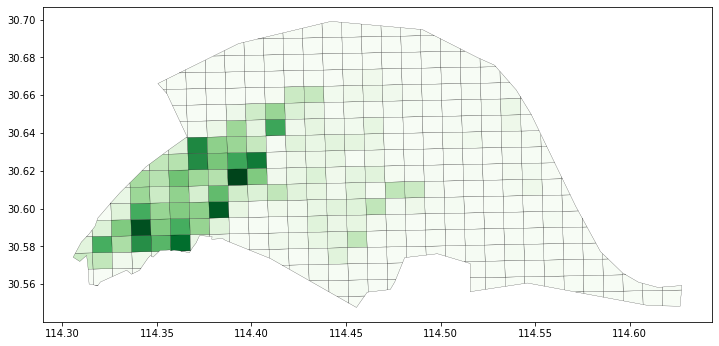

In [35]:
fig, ax = plt.subplots(figsize=(12, 12))
ax = qingshan_res3.plot(ax=ax, column='rsrp_sample_count', cmap =plt.cm.Greens, edgecolor='#000000', lw=0.2)

#关闭坐标轴
# ax.axis('off')
# plt.show()

# 评分系统

In [36]:
qingshan_res3.head(1)

,NAME,geometry,id,rsrp_sample_count,rsrp_weak,grid_id,有效栅格,弱覆盖栅格数量,严重弱覆盖栅格数量,2020年投诉量
0,青山,"POLYGON ((114.31361 30.56800, 114.31351 30.569...",region_grid_1,3080235.0,111791.0,54.0,54.0,25.0,2.0,9.0


In [37]:
qingshan_res4 = qingshan_res3[['id','rsrp_sample_count','rsrp_weak','grid_id','有效栅格','弱覆盖栅格数量','严重弱覆盖栅格数量','2020年投诉量','geometry']]

In [38]:
qingshan_res4.columns=['id', '总点', '弱点', '栅格数', '有效栅格', '弱覆盖栅格数量','严重弱覆盖栅格数量','投诉量','geometry']

In [39]:
qingshan_res4['覆盖率'] = 1 - qingshan_res4['弱点']/qingshan_res4['总点']

In [40]:
qingshan_res4['总点'].max()

13348721.0

In [41]:
qingshan_res4['k1']=25 * (qingshan_res4['总点']-1000)/(qingshan_res4['总点'].max()-1000)
qingshan_res4.loc[(qingshan_res4['总点']<1000),'k1']=0

In [42]:
qingshan_res4['k2']=25 * (qingshan_res4['严重弱覆盖栅格数量'])/(qingshan_res4['严重弱覆盖栅格数量'].max())

In [43]:
qingshan_res4['k3']=25 * (qingshan_res4['覆盖率']-0.7)/(0.936-0.7)
qingshan_res4.loc[(qingshan_res4['覆盖率']<0.7),'k3']=0
qingshan_res4.loc[(qingshan_res4['覆盖率']>=0.936),'k3']=25

In [44]:
qingshan_res4['k4']=25 * (qingshan_res4['投诉量'])/(qingshan_res4['投诉量'].max())

In [45]:
qingshan_res4['k']=qingshan_res4['k1']+qingshan_res4['k2']+qingshan_res4['k3']+qingshan_res4['k4']

In [46]:
qingshan_res4 = qingshan_res4.sort_values('k',ascending=False)

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


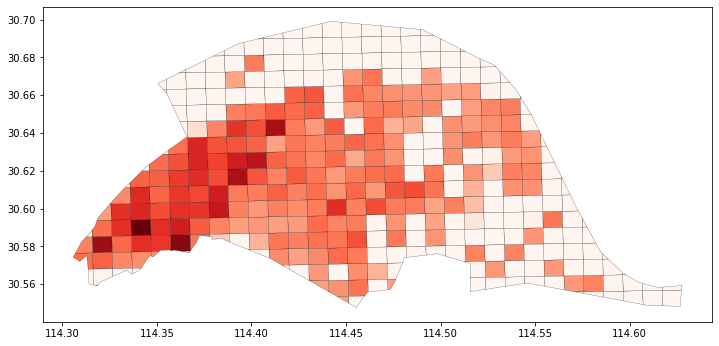

In [47]:
fig, ax = plt.subplots(figsize=(12, 12))
ax = qingshan_res4.plot(ax=ax, column='k', cmap =plt.cm.Reds, edgecolor='#000000', lw=0.2)


In [48]:
qingshan_res4['经纬度'] = qingshan_res4.centroid

In [49]:
qingshan_res4.to_clipboard()

# 选取top

In [51]:
data = pd.read_clipboard()

In [70]:
qingshan_res5 = qingshan_res4.merge(data,how='right',on='id')

In [ ]:
# qingshan_res5 = qingshan_res4.head(30)

In [ ]:
qingshan_res5.to_clipboard()

# 制作图层

In [57]:
qingshan_res5 = qingshan_res5.reset_index(drop=True)

In [58]:
qingshan_res5 = qingshan_res5.drop(columns='经纬度')

In [59]:
qingshan_res5.columns = ['id', 'rsrp_count', 'rsrp_weak', 'grid_count', 'grid_100_count', 'grid_weak', 'grid_weak_Serious', 'complain',
       'geometry', 'fgl', 'k1', 'k2', 'k3', 'k4', 'k']

In [ ]:
#制作tab图层
qingshan_res5.to_file('d:/qingshan.tab',driver="MapInfo File",encoding='gbk')

In [ ]:
qingshan_res5 = gpd.read_file('d:/qingshan.tab',encoding='gbk')

In [ ]:
qingshan_res5

In [60]:
#制作google图层

In [72]:
qingshan_res6 = qingshan_res5.reset_index()

In [73]:
qingshan_res6['lin'] = qingshan_res6.boundary

In [74]:
kml = simplekml.Kml()

In [75]:
def to_kml(x):
    lin = kml.newlinestring(
        name=x['id'],                   
        description=x[[ 'id','总点','弱点','栅格数','有效栅格','弱覆盖栅格数量','严重弱覆盖栅格数量','投诉量','覆盖率','k']].to_string(),
        coords=list(x['lin'].coords))
    lin.style.linestyle.color =simplekml.Color.changealphaint(245, 'ff00a5ff' )
    lin.style.linestyle.width= 5

In [76]:
qingshan_res6.apply(to_kml,axis=1)
kml.save('d:/shiyan.kml')
print('ok')

ok


# top30匹配周边的7734、催开、故障、优化、高负荷、干扰

In [ ]:
qingshan_res5.shape

In [ ]:
#导入7734汇总的数据

In [ ]:
data_7734 = pd.ExcelFile('G:/1-规划/1其他工作输出/20200603青山按照大栅格划分问题点/3-分析top解决方案/1基础数据/青山专属建设、优化、故障/汇总/建设、故障、优化汇总.xlsx')

In [ ]:
data_7734.sheet_names

In [ ]:
data_7734.sheet_names

In [ ]:
data_7734_sum = data_7734.parse(sheet_name='汇总')

In [ ]:
data_7734_sum.head(1)

In [ ]:
data_7734_sum.loc[data_7734_sum['区县']=='青山区'].shape

In [ ]:
p_7734 = mytools.gisn.add_points(data_7734_sum)

In [ ]:
top30_7734_sjoin = gpd.sjoin(qingshan_res5,p_7734)

In [ ]:
top30_7734_sjoin.columns

In [ ]:
top30_7734_sjoin.drop_duplicates('id').shape

In [ ]:
top30_7734_sjoin.drop_duplicates('唯一编号').shape

In [ ]:
top30_7734_sjoin.drop_duplicates('唯一编号').shape[0]/data_7734_sum.loc[data_7734_sum['区县']=='青山区'].shape[0]

In [ ]:
top30_7734_sjoin.drop_duplicates('唯一编号').groupby('分类').count()

# 匹配现网小区

In [ ]:
gongcan= pd.read_csv('G:/1-规划/工参/工参数据/ltejizhan20200529.csv',encoding='gbk',usecols=['小区CGI(*)', 'RRU经度', 'RRU纬度','覆盖场景'])

In [ ]:
gongcan.columns

In [ ]:
changjing_shuoming = pd.read_csv('G:/1-规划/表格类保存/场景说明.csv',encoding='gbk')

In [ ]:
changjing_shuoming.head(1)

In [ ]:
gongcan_use = gongcan.merge(changjing_shuoming,how='left',left_on='覆盖场景',right_on='类型ID')

In [ ]:
gogncan_p = mytools.gisn.points_coverage_merge(gongcan_use.loc[gongcan_use['RRU经度']>0],'RRU经度', 'RRU纬度')

In [ ]:
gogncan_p2 = mytools.gisn.add_points(gogncan_p, 'RRU经度', 'RRU纬度')

In [ ]:
gogncan_p2 = mytools.gisn.add_points(gogncan_p, 'RRU经度', 'RRU纬度')

In [ ]:
top30_gongcan_sjoin = gpd.sjoin(qingshan_res5,gogncan_p2)

In [ ]:
top30_gongcan_sjoin.columns

In [ ]:
top30_gongcan_sjoin.head(1)

In [ ]:
res_changjing = top30_gongcan_sjoin.drop_duplicates('小区CGI(*)').groupby([ '场景类型']).agg({'id':'count'})

In [ ]:
res_changjing.to_clipboard()

# 匹配软采负荷干扰

In [ ]:
#软采小区处理

In [ ]:
ruancai = pd.read_csv('G:/1-规划/1其他工作输出/20200603青山按照大栅格划分问题点/3-分析top解决方案/1基础数据/覆盖/汇总-按照采样点排序去重.csv',
    encoding='gbk')

In [ ]:
ruancai_use = ruancai[[ 'eutrancell_cgi', 'rsrp_sample_count', 'rsrp_weak', 'RRU经度', 'RRU纬度']]

In [ ]:
top30_gongcan_sjoin.groupby([ '区域类型']).agg({'id':'count'})

In [ ]:
ruancai_use['fgl'] = 1 - ruancai_use['rsrp_weak']/ruancai_use['rsrp_sample_count']

In [ ]:
ruancai_use = ruancai_use.loc[ruancai_use['fgl']<0.9]

In [ ]:
ruancai_p = mytools.gisn.add_points(ruancai_use, 'RRU经度', 'RRU纬度')

In [ ]:
#干扰小区处理

In [ ]:
ganrao = pd.read_csv('G:/1-规划/1其他工作输出/20200603青山按照大栅格划分问题点/3-分析top解决方案/1基础数据/干扰/干扰小区汇总.csv',
    encoding='gbk')

In [ ]:
ganrao_use = ganrao.merge(gongcan,how='left',left_on='小区ID',right_on='小区CGI(*)').drop_duplicates('小区ID')[['小区ID','RRU经度','RRU纬度']]

In [ ]:
ganrao_p = mytools.gisn.add_points(ganrao_use,'RRU经度','RRU纬度')

In [ ]:
ganrao.head(1)

In [ ]:
#负荷小区处理

In [ ]:
fuhe = pd.read_csv('G:/1-规划/1其他工作输出/20200603青山按照大栅格划分问题点/3-分析top解决方案/1基础数据/高负荷/高负荷汇总.csv',
    encoding='gbk')

In [ ]:
fuhe.head(1)

In [ ]:
fuhe_use = fuhe.merge(gongcan,how='left',left_on='CGI',right_on='小区CGI(*)').drop_duplicates('CGI')[['CGI','RRU经度','RRU纬度']]

In [ ]:
fuhe_p = mytools.gisn.add_points(fuhe_use,'RRU经度','RRU纬度')

In [ ]:
#匹配到大栅格

In [ ]:
rancai_top_sjoin = gpd.sjoin(qingshan_res5,ruancai_p)

In [ ]:
ganrao_top_sjoin = gpd.sjoin(qingshan_res5,ganrao_p)

In [ ]:
fuhe_top_sjoin = gpd.sjoin(qingshan_res5,fuhe_p)

In [ ]:
#计算结果

In [ ]:
#软采

In [ ]:
rancai_top_sjoin.to_clipboard()

In [ ]:
rancai_top_sjoin.drop_duplicates('eutrancell_cgi').shape

In [ ]:
#干扰

In [ ]:
ganrao_top_sjoin.to_clipboard()

In [ ]:
ganrao_top_sjoin.drop_duplicates('小区ID').shape

In [ ]:
#负荷

In [ ]:
fuhe_top_sjoin.to_clipboard()

In [ ]:
fuhe_top_sjoin.drop_duplicates('CGI').shape

In [ ]:
#现网

In [ ]:
top30_gongcan_sjoin.drop_duplicates('小区CGI(*)').shape

In [ ]:
#写word用

In [ ]:
id = 'region_grid_138'

In [ ]:
qingshan_res5.columns

In [ ]:
b=qingshan_res5.loc[qingshan_res5['id']==id][['总点','覆盖率','弱覆盖栅格数量','严重弱覆盖栅格数量','投诉量']].reset_index()

In [ ]:
xq=str(top30_gongcan_sjoin.loc[top30_gongcan_sjoin['id']==id].agg({'小区CGI(*)':'count'})['小区CGI(*)'])

In [ ]:
'该区域主要弱覆盖包括***以及周边楼宇。区域内共计{}个小区，整体采样点{}个相对较多，覆盖率为{}， \
区域内有{}个栅格覆盖率小于93.6%，{}个栅格覆盖率低于70%，20年投诉共计{}个。 \
'.format(xq,int(b['总点'][0]),str(b['覆盖率'][0]*100)[:5]+'%',int(b['弱覆盖栅格数量'][0]),int(b['严重弱覆盖栅格数量'][0]),int(b['投诉量'][0]))

In [ ]:
'区域内'+xq+ \
'个现网小区中，有'+str(rancai_top_sjoin.loc[rancai_top_sjoin['id']==id].agg({'eutrancell_cgi':'count'})['eutrancell_cgi'])+ \
'个弱覆盖小区，'+str(ganrao_top_sjoin.loc[ganrao_top_sjoin['id']==id].agg({'小区ID':'count'})['小区ID'])+ \
'个为干扰小区，'+str(fuhe_top_sjoin.loc[fuhe_top_sjoin['id']==id].agg({'CGI':'count'})['CGI'])+'个为高负荷小区'#负荷

In [ ]:
a=top30_7734_sjoin.loc[top30_7734_sjoin['id']==id].groupby('分类').agg({'唯一编号':'count'})

In [ ]:
a

In [ ]:
'区域内与7734工单重合{}单，其中可新建站点{}个，可优化小区{}个，可进行维护处理站点{}个。 \
可根据实际情况进行推动工单处理进度。改善区域的网络质量。'.format(a.sum()[0],a.loc['建设'][0],a.loc['优化'][0],a.loc['故障'][0])